# Bot CNN classifier

A CNN classifier trained to distinguish between humans and bots based on tweet content alone.

Human users from the 'verified-2019' dataset at (tweets must be downloaded seperately): \
https://botometer.osome.iu.edu/bot-repository/datasets.html

Bots from Russia IRA dataset: \
https://www.kaggle.com/datasets/paultimothymooney/russian-political-influence-campaigns \
https://www.kaggle.com/code/kmader/from-hate-speech-to-russian-bot-tweets/notebook

In [1]:
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout, concatenate
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

Using TensorFlow backend.
/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

### Get the data

In [12]:
# Data configurations
use_all_IRA_datasets = False
specific_IRA_dataset = ['IRAhandle_tweets_1.csv'] # Can be a list of a single dataset or multiple
filter_on_english = True

#### Bot dataset

In [13]:
import glob
import os
import re
import pandas as pd

IRA_path = 'data/IRA_tweets/'

russian_troll_tweets = None
if use_all_IRA_datasets is True:
    IRA_files = glob.glob(IRA_path + "*.csv")
    
    li = []

    for filename in sorted(IRA_files):
        print(filename)
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    russian_troll_tweets = pd.concat(li, axis=0, ignore_index=True)

elif use_all_IRA_datasets is False and len(specific_IRA_dataset) > 1:
    russian_troll_tweets = None
    filepath = IRA_path
    for filename in sorted(os.listdir(IRA_path)):
        if filename in specific_IRA_dataset:
            print(filename)
            russian_troll_tweets_i = pd.read_csv(IRA_path + filename)
            if russian_troll_tweets is not None:
                russian_troll_tweets = pd.concat([russian_troll_tweets, russian_troll_tweets_i])
            else:
                russian_troll_tweets = russian_troll_tweets_i
                
elif use_all_IRA_datasets is False and len(specific_IRA_dataset) == 1:
    russian_troll_tweets = pd.read_csv(IRA_path + specific_IRA_dataset[0])

# Filtering
if filter_on_english is True:
    russian_troll_tweets = russian_troll_tweets.drop(russian_troll_tweets[~russian_troll_tweets['language'].str.contains('English')].index)

russian_troll_tweets = russian_troll_tweets.dropna(subset=df.select_dtypes(float).columns, how='all')
russian_troll_tweets.reset_index(drop=True, inplace=True)

#### Human dataset

In [14]:
human_tweets = pd.read_csv('data/tweets_human_200peruser.csv')

### Preparing data

This involves vectorising the tweets and padding them

In [16]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define vectorisation parameters
max_features = 20000
maxlen = 100

# Get the sentances into a list
list_sentences_bots = russian_troll_tweets["content"].fillna("Invalid").values
list_sentences_humans = human_tweets["Text"].fillna("Invalid").values
list_sentences_train = np.concatenate((list_sentences_humans, list_sentences_bots), axis = 0)

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

# train data
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
x = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)

y_humans = np.zeros((len(list_sentences_humans)))
y_bots = np.ones((len(list_sentences_bots)))
y = np.concatenate((y_humans, y_bots), axis = 0)
y = to_categorical(y)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### Building and training the model

In [17]:
def build_model(conv_layers = 2, max_dilation_rate = 4):
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Dropout(0.25)(x)
    x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    prefilt_x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    out_conv = []
    # dilation rate lets us use ngrams and skip grams to process 
    for dilation_rate in range(max_dilation_rate):
        x = prefilt_x
        for i in range(3):
            x = Conv1D(32*2**(i), 
                       kernel_size = 3, 
                       dilation_rate = 2**dilation_rate)(x)    
        out_conv += [Dropout(0.5)(GlobalMaxPool1D()(x))]
    x = concatenate(out_conv, axis = -1)    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy'])

    return model

model = build_model()
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 128)     2560000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 128)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 256)      98560       dropout_1[0][0]                 

In [18]:
# Because the dataset is massive and takes forever to run the whole thing
x_train_short = x_train[:20000]
y_train_short = y_train[:20000]
x_test_short = x_test[:2000]
y_test_short = y_test[:2000]

In [19]:
load_weights = True
file_path="weights.hdf5"
if load_weights is True:
    model.load_weights(file_path)
    
else:
    batch_size = 512
    epochs = 3

    checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

    callbacks_list = [checkpoint, early] #early
    model.fit(x_train_short, y_train_short, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_split=0.1, 
              callbacks=callbacks_list)
    model.load_weights(file_path)

In [20]:
y_pred = model.predict(x_test_short, batch_size=1024, verbose=True)
y_pred_rounded = np.round(y_pred)


2000/2000 [==============================] - 6s 3ms/step


In [21]:
from sklearn.metrics import accuracy_score
y_test_short_decoded = np.argmax(y_test_short, axis=-1)
print("Acc", accuracy_score(y_test_short, y_pred_rounded[:2000]))
from sklearn.metrics import confusion_matrix

y_pred_rounded_decoded = np.argmax(y_pred_rounded, axis=-1)
species = np.array(y_test_short_decoded)
predictions = np.array(y_pred_rounded_decoded)
confusion_matrix = confusion_matrix(species, predictions)

print(confusion_matrix)

Acc 0.648
[[748 401]
 [300 551]]


### Try with new data

In [39]:
# Just pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/Users/ms731/opt/anaconda3/envs/tensorflow-py3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


#### Load in

In [42]:
ukraine_tweets = pd.read_csv('data/tweets_raw_en_df_peacetalks.csv')
ukraine_tweets_feb_march = pd.read_csv('data/tweets_raw_en_df_individual_bot_exploration_ukraine_feb-march1800.csv')
ukraine_tweets_feb_march = ukraine_tweets_feb_march[:1800]
rugby_tweets_feb_march = pd.read_csv('data/tweets_raw_en_df_individual_bot_exploration_rugby_march1800.csv')
rugby_tweets_feb_march = rugby_tweets_feb_march[:1800]

list_sentences_ukraine = ukraine_tweets["Text"].fillna("Invalid").values 
list_sentences_ukraine_feb_march = ukraine_tweets_feb_march["Text"].fillna("Invalid").values 
list_sentences_rugby_feb_march = rugby_tweets_feb_march["Text"].fillna("Invalid").values 

# train data
list_tokenized_ukraine = tokenizer.texts_to_sequences(list_sentences_ukraine)
x_ukraine = sequence.pad_sequences(list_tokenized_ukraine, maxlen=maxlen)
list_tokenized_ukraine_feb_march = tokenizer.texts_to_sequences(list_sentences_ukraine_feb_march)
x_ukraine_feb_march = sequence.pad_sequences(list_tokenized_ukraine_feb_march, maxlen=maxlen)
list_tokenized_rugby_feb_march = tokenizer.texts_to_sequences(list_sentences_rugby_feb_march)
x_rugby_feb_march = sequence.pad_sequences(list_tokenized_rugby_feb_march, maxlen=maxlen)


y_pred_ukraine = model.predict(x_ukraine, batch_size=1024, verbose=True)
y_pred_ukraine_decoded = y_pred_ukraine[:,1]
y_pred_ukraine_feb_march = model.predict(x_ukraine_feb_march, batch_size=1024, verbose=True)
y_pred_ukraine_feb_march_decoded = y_pred_ukraine_feb_march[:,1]
y_pred_rugby_feb_march = model.predict(x_rugby_feb_march, batch_size=1024, verbose=True)
y_pred_rugby_feb_march_decoded = y_pred_rugby_feb_march[:,1]

ukraine_tweets_scores = ukraine_tweets.copy()
ukraine_tweets_scores['Bot scores'] = y_pred_ukraine_decoded
ukraine_tweets_scores_feb_march = ukraine_tweets_feb_march.copy()
ukraine_tweets_scores_feb_march['Bot scores'] = y_pred_ukraine_feb_march_decoded
rugby_tweets_scores_feb_march = rugby_tweets_feb_march.copy()
rugby_tweets_scores_feb_march['Bot scores'] = y_pred_rugby_feb_march_decoded

1800/1800 [==============================] - 4s 2ms/step


#### Explore results

In [43]:
ukraine_tweets_scores.loc[np.where((y_pred_ukraine_decoded > 0.75))[0]]

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created,Bot scores
0,0,2022-03-27 23:05:28+00:00,1508218678000508934,Zelensky says Ukraine ready to discuss neutrality in peace talks with Russia https://t.co/fCO8YXdxYi,onej258,0,WSS News,en,2022-02-20,0.952722
3,3,2022-03-27 21:59:00+00:00,1508201948801032194,Russian and Ukrainian delegations to hold new round of peace talks\n\n#RussiaUkraineWar #Ukraine #Russia \nhttps://t.co/TuKzi5KP5g,WeForNews2,0,WeForNews,en,2022-01-13,0.934751
7,7,2022-03-27 20:05:37+00:00,1508173414569283591,Venue chosen for Russia-Ukraine peace talks — RT World News https://t.co/g5jJ3EAtGh,AngusMemes4,0,𝔸𝕟𝕘𝕦𝕤𝕄𝕖𝕞𝕖𝕤,en,2022-03-03,0.977263
8,8,2022-03-27 20:01:27+00:00,1508172367863992329,"President's Office says Ukraine, Russia foreign ministers ready to meet for peace talks https://t.co/KSwjV3PCzO",JustynaTosiek,0,Justyn4321,en,2022-02-27,0.818426
11,11,2022-03-27 19:38:50+00:00,1508166674893189129,"Trump Wouldn't Be 'Capable' Of Ukraine Peace Talks With Moscow, Says John Bolton https://t.co/qaMbqb3jIV via @YahooNews",AllKnowing7777,0,All Knowing,en,2022-02-28,0.840433
19,19,2022-03-27 18:11:20+00:00,1508144655757717513,@KnowlesYves Yes don't be shocked if Ukraine and Russia talks collapse because of Biden remarks now Putin has no interest in peace talks defacto russian nuclear policy any attempt of regime chance means 1st strike,rocketsjay1,0,Jay Rockets,en,2022-02-01,0.964115
30,30,2022-03-27 12:00:03+00:00,1508051217578045441,"Trump would not be 'capable' of holding Ukraine-Russia peace talks, says his former national security adviser John Bolton https://t.co/wZ74p5NJF3",tellmetimes,0,Tellme Times,en,2022-01-08,0.907301
37,37,2022-03-27 02:52:01+00:00,1507913303003119622,@tylerpager Prezident Putin was also inarticulate when he said military operation when he meant full scale war.\nSome more examples\nRussians don't kill civilians\nUkrainians are bombing Ukraine\nPeace talks without ceasefire\nDenazification,AbstractEngg,0,Abstract Engineer,en,2022-02-13,0.869250
52,52,2022-03-27 23:08:42+00:00,1508219491032829952,30th day: Let's Pray the Rosary for Peace in Ukraine 🌻🙏 https://t.co/YmqforOK5K,Polgarz04,0,🌻🌻🌻,en,2022-02-28,0.931853
69,69,2022-03-27 22:24:42+00:00,1508208418393317381,@JimmySecUK @BSBonner At least mr @GerardAraud knows how to act if there is someday French-Russian military conflict.\n\nUntil then - stay off from tarnishing Ukraine to fight for their homeland and for the peace in Europe!,jamesro7070,0,James R,en,2022-03-06,0.950920


In [147]:
ukraine_tweets_scores.loc[np.where((y_pred_ukraine_decoded > 0.75))[0]]

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created,Bot scores
84,84,2022-02-19 23:56:57+00:00,1495185670758879241,"@TeachSUFC Makes sense. Ukraine's armed forces, tanks, planes, ships far outnumber Russia's military.............",laakr1,1,Laak 🇺🇦🇪🇺🇳🇱😷💉💪,en,2011-04-01,0.942965
143,143,2022-02-19 23:55:22+00:00,1495185272530771976,@RonFilipkowski @JDVance1 should lose his Senate race as people do care about Russia invading the Ukraine.,MollyBrown28,0,Molly Brown,en,2011-11-01,0.924052
220,220,2022-02-19 23:52:36+00:00,1495184575777099780,"Trump, aka Putin's Puppet, is cheering for the Authoritarian Dictator; #PATHETIC ...\n\nRT @RpsAgainstTrump: Why hasn’t Donald Trump said a word about Russia’s aggression against Ukraine?",purpleH2Oski,0,Doug Goodman,en,2009-03-12,0.943566
289,289,2022-02-19 23:49:52+00:00,1495183888251080709,@POTUS Ukraine has a government and military controlled by Nazi supporters who are literally terrorists. Russia should invade these Nazis.,MoreWillF,0,Will,en,2021-09-02,0.910871
344,344,2022-02-19 23:48:10+00:00,1495183458532053005,Is MSM seriously trying to blame high gas prices on Russia/Ukraine? 🤣🤡🌎,TheBenTheBoca,2,Ben “Independent Thinker” Ray 121,en,2011-07-27,0.912015
414,414,2022-02-19 23:45:48+00:00,1495182865327345670,Does anybody knows what are those [Z] on the russian hardware? #russia #Ukraine,hcdigo,1,Rodrigo Vargas,en,2021-12-23,0.844372
598,598,2022-02-20 23:56:27+00:00,1495547931419549698,"*WW2 end\n\n*1949 NATO start\n\n*USSR fall\n\n*'99 Baltics join\n\n*Russia warns\n\n*'04 Lat, Lith, Est join\n\n*Rus warns\n\n*'08 NATO allude to Gerogia Ukraine\n\n*'08 Rus invades Georgia\n\n*'09 US/Rus Reset (fails '14)\n\n*'14 Rus invades Crimea/Ukr\n\n...\n\n*'22 Rus invades Ukr\n\nHow it goes, IMHO",OphirGottlieb,34,Ophir Gottlieb,en,2009-12-28,0.802430
604,604,2022-02-20 23:56:19+00:00,1495547896057454597,US warns citizens of terror attacks in Russia as tensions rise with Ukraine https://t.co/yjg4pN29QU,NaijaNewsWire,0,Naija News Agency,en,2014-07-01,0.945681
734,734,2022-02-20 23:52:20+00:00,1495546895552630785,That's the truth.\nhttps://t.co/4DaTX0Nkw7\n\n#Russia #USA #ukraine #NATO,IShamsan,1,I.Shamsan,en,2010-08-27,0.782825
834,834,2022-02-20 23:48:02+00:00,1495545811618443273,"@cnnbrk If anybody start a war, it won't be Ukraine, or Russia!!!!!",darksideofthemo,49,Strange things..👻🇧🇻,en,2011-11-04,0.937404


In [44]:
ukraine_tweets_scores_feb_march.loc[np.where((y_pred_ukraine_feb_march_decoded > 0.75))[0]]

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created,Astroturf,Fake follower,Financial,Other,Overall,Self declared,Spammer,Cap,Bot scores
6,6,2022-02-19 23:59:39+00:00,1495186350483681287,Ukraine: Russia plans biggest war in Europe since 1945 - Boris Johnson https://t.co/fWcVsYdtXq,dave1agar,0,Dave Agar,en,2009-03-11,0.35,0.35,0.02,0.43,0.33,0.01,0.02,0.785221,0.761841
26,26,2022-02-19 23:58:58+00:00,1495186175560228866,Boris Johnson says “Russia plans biggest war in Europe since 1945.” Hilarious!! I should write a novel about the “biggest war”! 😃😄 #Russia #Ukraine,williamalsharif,0,William Al-Sharif,en,2009-05-17,0.07,0.24,0.05,0.77,0.77,0.55,0.23,0.805478,0.874445
47,47,2022-02-19 23:57:47+00:00,1495185879475777539,"@leahmcelrath @chadloder Mike's behavior is borderline obscene, but Emily's takes on Russia/Ukraine are shit.",TaoOfGir,1,"TaoOfGir ""Those damn humans...""",en,2021-08-19,0.31,0.09,0.00,0.15,0.30,0.01,0.04,0.775989,0.876731
52,52,2022-02-19 23:57:31+00:00,1495185810467049472,"@Ena500 I’m no fan of Russia, or communism look at my bio (free Tibet) I’m just honest. Didn’t Ukraine back Hitler in WW2 of course they did.",Davey1969Davey,0,Gareth Davey 3.5% 🏴󠁧󠁢󠁷󠁬󠁳󠁿🇵🇸,en,2013-06-04,0.64,0.13,0.00,0.19,0.16,0.00,0.00,0.621687,0.996203
79,79,2022-02-19 23:56:21+00:00,1495185516895088644,Long live Ukraine! 🇺🇦 Russia’s sophisticated disinformation and obsession with obstructing Ukraine’s right to self-determination will never win. #Ukraine #democracy https://t.co/mq1R68RCNN,DPorteous_,0,Dan,en,2017-12-29,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.000000,0.789092
82,82,2022-02-19 23:56:17+00:00,1495185503078989827,Ukraine: Russia plans biggest war in Europe since 1945 - Boris Johnson https://t.co/WUUSzVaHfO,KMGaither,2,Karen Gaither,en,2009-04-23,0.07,0.04,0.01,0.19,0.06,0.02,0.00,0.362646,0.761841
90,90,2022-02-19 23:56:00+00:00,1495185429011828741,"As Putin Oversees Nuclear Drills, US Says Russia 'Poised To Strike' Ukraine - NDTV https://t.co/DzpNsUma1n",donatela0626,1,@donatela0626,en,2021-11-11,0.22,0.24,0.04,0.54,0.32,0.01,0.05,0.782636,0.965996
97,97,2022-02-19 23:55:45+00:00,1495185367074365440,"@JeffreyAWillia4 @WonderFi Ukraine/Russia tensions, crypto bear market, WonderFi is not down anymore than a lot of tech stocks right now",AjfaKane,0,Ajfa Kane,en,2021-11-02,0.06,0.34,0.05,0.10,0.29,0.02,0.13,0.771781,0.859132
107,107,2022-02-19 23:55:26+00:00,1495185286208405516,Putin’s arguments don’t stack up. He could have proposed an international treaty to protect Russia’s security. Invading Ukraine makes no sense.,PCGuru07,0,Craig P Sheppard🇺🇦🇬🇧 Slava Ukraini,en,2011-01-24,0.33,0.05,0.00,0.12,0.06,0.01,0.01,0.362646,0.906107
110,110,2022-02-19 23:55:22+00:00,1495185272530771976,@RonFilipkowski @JDVance1 should lose his Senate race as people do care about Russia invading the Ukraine.,MollyBrown28,0,Molly Brown,en,2011-11-01,0.17,0.05,0.04,0.21,0.03,0.00,0.00,0.278726,0.976509


In [45]:
rugby_tweets_scores_feb_march.loc[np.where((y_pred_rugby_feb_march_decoded > 0.75))[0]]

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language,User Created,Astroturf,Fake follower,Financial,Other,Overall,Self declared,Spammer,Cap,Bot scores
2,2,2022-03-01 23:57:15+00:00,1.498810e+18,Good luck to the 500 school pupils coming to play rugby @AmpleforthColl tomorrow @EngRugbySchools @YorkshireRugby @EnglandRugby https://t.co/22xAn8fWGI,HarrietLangdale,6,Harriet Langdale,en,2012-10-20,0.08,0.04,0.03,0.36,0.11,0.03,0.01,0.502712,0.750171
4,4,2022-03-01 23:56:07+00:00,1.498809e+18,Y’all know I love rugby with my whole heart but I’m starting to wish I played softball through college,alliwhit_,6,Alli Whit,en,2012-08-26,0.11,0.10,0.00,0.09,0.03,0.07,0.00,0.278726,0.980585
6,6,2022-03-01 23:55:30+00:00,1.498809e+18,Former rugby league star Manu Vatuvei sentenced on meth import charge https://t.co/8w8XSDAH79,MrHilariouskiwi,7,Mr. Kiwi,en,2019-03-05,0.25,0.09,0.00,0.11,0.03,0.00,0.00,0.278726,0.938725
9,9,2022-03-01 23:53:36+00:00,1.498809e+18,@SixNationsRugby @phlaimeaux this is who is your favourite David with Groucho Marx mask.,ug_boot,0,ugboot,en,2014-01-02,0.05,0.60,0.13,0.54,0.60,0.51,0.24,0.796725,0.965210
13,13,2022-03-01 23:52:35+00:00,1.498808e+18,Super Rugby Aupiki start in doubt as Covid-19 takes hold https://t.co/CxrN2uwCW6,borowest,0,Unscrambled,en,2011-04-21,0.14,0.56,0.03,0.84,0.84,0.63,0.23,0.828755,0.953878
16,16,2022-03-01 23:51:33+00:00,1.498808e+18,Former rugby league star Manu Vatuvei sentenced on meth import charge https://t.co/V4eViO0TP6,aakefu,4,Aminiasi Kefu,en,2014-07-17,0.12,0.13,0.15,0.44,0.18,0.00,0.00,0.659646,0.938725
17,17,2022-03-01 23:50:34+00:00,1.498808e+18,#BREAKING Former rugby league star Manu Vatuvei has been sentenced to three years and seven months in prison for importing methamphetamine.\n\nhttps://t.co/4kO9hIKZKS,radionz,17,RNZ,en,2009-05-27,0.03,0.23,0.00,0.61,0.61,0.10,0.01,0.796667,0.835989
18,18,2022-03-01 23:50:31+00:00,1.498808e+18,‘We can’t ignore it’: SA Rugby’s plan to bring women’s rugby out of the shadows | Sport https://t.co/rAKdbKzOkq,satarknews,0,Satark News,en,2020-04-07,0.08,0.42,0.11,0.75,0.82,0.82,0.48,0.819915,0.992785
19,19,2022-03-01 23:50:06+00:00,1.498808e+18,A decision will be made this afternoon whether Super Rugby Aupiki will go ahead as planned this weekend https://t.co/jcMVwDjYDH,NZStuffSport,0,Stuff Sport,en,2008-08-08,0.11,0.27,0.00,0.81,0.81,0.52,0.12,0.816204,0.851674
23,23,2022-03-01 23:49:45+00:00,1.498808e+18,Former rugby league star Manu Vatuvei sentenced to 3 years and 7 months in prison for importing meth https://t.co/E5uKVnP5AO,rnz_news,7,RNZ News,en,2007-06-22,0.11,0.20,0.00,0.79,0.79,0.44,0.05,0.810078,0.801255


## Data manipulation investigation

One thing we can experiment with is replacing some of the words in the bot dataset with ones we think are relevant to bots in Ukraine e.g. USA/America -> Russia/Ukraine, Trump -> Putin, or even Trump -> Zelensky if the model picks up on hot-headed opinions even if they are nothing alike. 

Let's find some of the most common words in the bot dataset

In [48]:
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
import matplotlib.pyplot as plt

In [78]:
import numpy as np
russian_troll_tweets.reset_index(drop=True, inplace=True)
#np.where(type(russian_troll_tweets['content']) == float)

bad_values_idx = []
for i, tex in enumerate(russian_troll_tweets['content']):
    if type(tex) != str:
        print(i-1, tex)
        bad_values_idx.append(i-1)

russian_troll_tweets_d = russian_troll_tweets.drop(bad_values_idx)

1091646 nan


In [97]:
print(russian_troll_tweets.iloc[1])
russian_troll_tweets = russian_troll_tweets.drop(bad_values_idx, axis=1, inplace=True)
russian_troll_tweets.head()

AttributeError: 'NoneType' object has no attribute 'iloc'

In [108]:
russian_troll_tweets.dropna(subset=df.select_dtypes(float).columns, how='all', inplace=True)

In [110]:
russian_troll_tweets=russian_troll_tweets.dropna()

There are 30996020 words in the combination of all review.


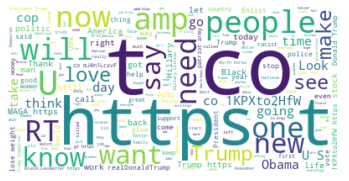

In [49]:
import matplotlib.pyplot as plt
text = " ".join(text for text in russian_troll_tweets.content)
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()